# Ohmic effect
When the particle flux is high, there is a big avalanche. The electrons and ions in the gass induce currents in the protection circuits and through the (variable) resistor in the HV filter. These currents cause a voltage drop, which then results in a gain drop. This gain drop in turn results in an efficiency drop at high rate. 

This effect can be studied by determining the efficiency of the ME0 detector as a function of the attenuation of the source.

In [1]:
%load_ext autoreload
%autoreload 2
from testbeam import *

/eos/home-s/sivander/SWAN_projects/tutorial/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/eos/home-s/sivander/SWAN_projects/tutorial/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Calculate efficiency for all runs

/eos/home-s/sivander/SWAN_projects/tutorial/testbeam.py:195: RuntimeWarning: invalid value encountered in sqrt
  xres_mean_std[eta-1] = np.sqrt(np.diag(covariance_exponential))[1]
/eos/home-s/sivander/SWAN_projects/tutorial/testbeam.py:196: RuntimeWarning: invalid value encountered in sqrt
  xres_sigma_std[eta-1] = np.sqrt(np.diag(covariance_exponential))[2]
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/o

     Run  start  stop duration  beam source attenuation compensation  \
4    027    NaN   NaN      NaN  muon     on         2.2           no   
6    029    NaN   NaN      NaN  muon     on         1.5           no   
7    030    NaN   NaN      NaN  muon     on         1.5          yes   
8    069    NaN   NaN      NaN  muon     on          46           no   
9    070    NaN   NaN      NaN  muon     on          46          yes   
..   ...    ...   ...      ...   ...    ...         ...          ...   
258  382    NaN   NaN      NaN  muon     on          22          yes   
265  393    NaN   NaN      NaN  muon     on         1.5          yes   
266  394    NaN   NaN      NaN  muon     on         1.5          yes   
267  395    NaN   NaN      NaN  muon     on         1.5          yes   
268  397    NaN   NaN      NaN  muon     on         1.5          yes   

     WP Standard  WP Random  ...              Firmware  GOOD run?  \
4            NaN        NaN  ...  backend-rx-sync-fifo        yes 

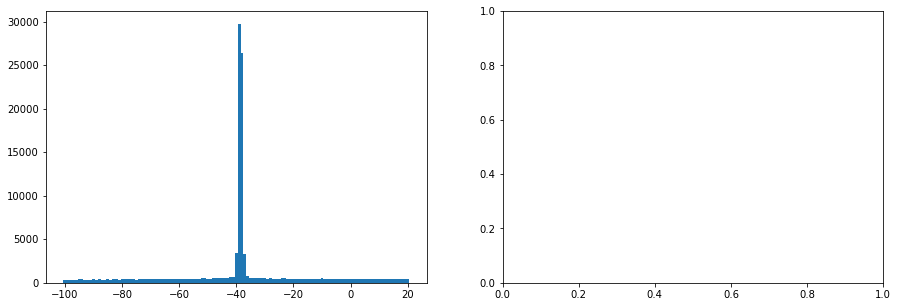

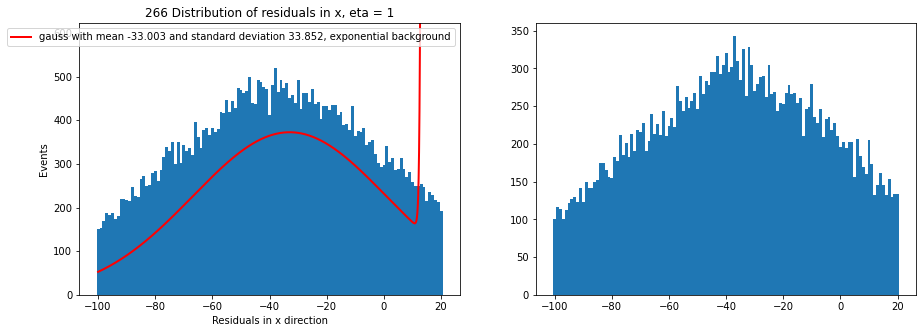

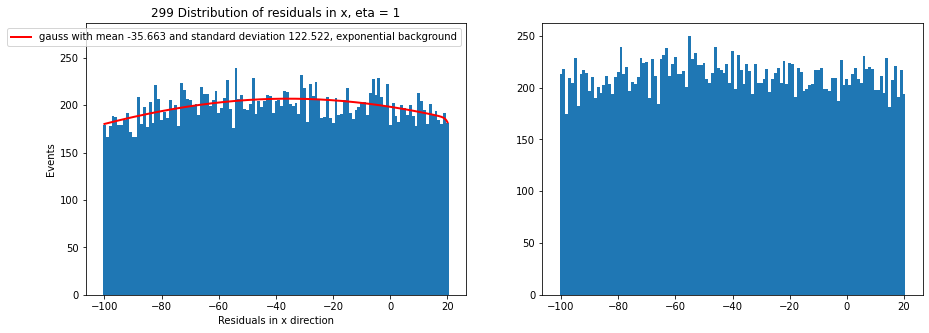

In [2]:
file = read_runinfo("GEM GIF++ testbeam 2022 - Runs.csv")
file = add_efficiency(file)
file = add_rate(file, "rate_attenuation.txt")
print(file)

### Manually remove runs for which the residual distributions or fits look bad

In [3]:
badruns = ['191', '218', '222', '232', '239', '243', '258', '267', '271', '272', '274', 
           '301', '302', '326', '333', '192', '196', '300', '304', '393', '394', '397']

for runnumber in badruns:
    file = remove_run(file, runnumber)

Save some copies of variables to work more easily.

In [4]:
efficiencies = file["calculated_efficiencies"]
efficiency_errors = file["efficiency_errors"]
attenuation = file["attenuation"]
compensation = file["compensation"]
threshold = file["Average ME0 threshold"]
HV_filter = file["HV filter standard"]
rates = file["source_rate"]
rate_errors = file["source_rate_error"]

### Plot efficiency vs attenuation

In [5]:
# Also could you plot the x axis in reverse (attenuation to the power of minus 1)? 
# Since that is proportional or at least monothonically correlated with the flux
inv_attenuation = [math.inf if (x == '/' or x == '') else 1/float(x) for x in attenuation]
file = file.assign(inverse_attenuation = inv_attenuation)

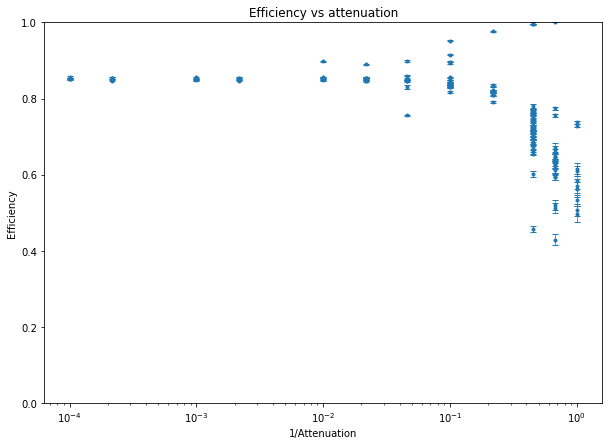

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.errorbar(inv_attenuation, efficiencies, yerr=efficiency_errors, ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='.')
ax.set(xlabel="1/Attenuation", ylabel="Efficiency", title="Efficiency vs attenuation", ylim=(0, 1), xscale='log')

plt.show()

### Distinguish runs with and without compensation

In [7]:
compensated_mask = [(comp == 'yes') for comp in compensation]
not_compensated_mask = [(comp == 'no') for comp in compensation]

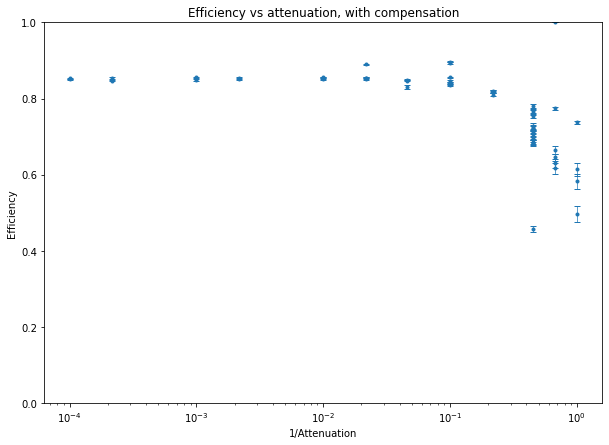

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.errorbar(list(compress(inv_attenuation, compensated_mask)), 
            list(compress(efficiencies, compensated_mask)), 
            yerr=list(compress(efficiency_errors, compensated_mask)),
            ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='.')
    
ax.set(xlabel="1/Attenuation", ylabel="Efficiency", title="Efficiency vs attenuation, with compensation", ylim=(0, 1), xscale='log')

plt.show()

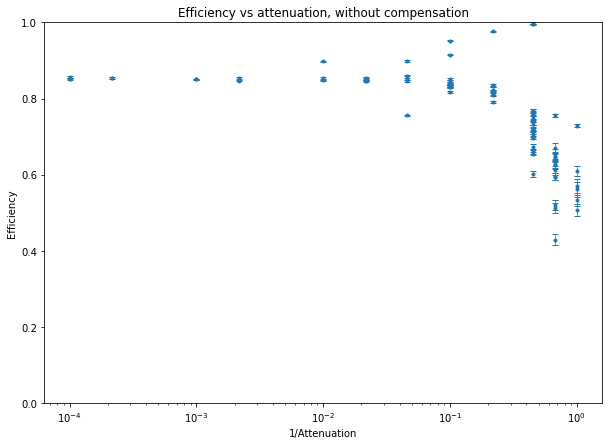

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.errorbar(list(compress(inv_attenuation, not_compensated_mask)), 
            list(compress(efficiencies, not_compensated_mask)),
            yerr=list(compress(efficiency_errors, not_compensated_mask)), 
            ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='.')
    
ax.set(xlabel="1/Attenuation", ylabel="Efficiency", title="Efficiency vs attenuation, without compensation", ylim=(0, 1), xscale='log')

plt.show()

In [10]:
# Only look at runs with threshold 25.
threshold_mask = [(thres == '25') for thres in threshold]

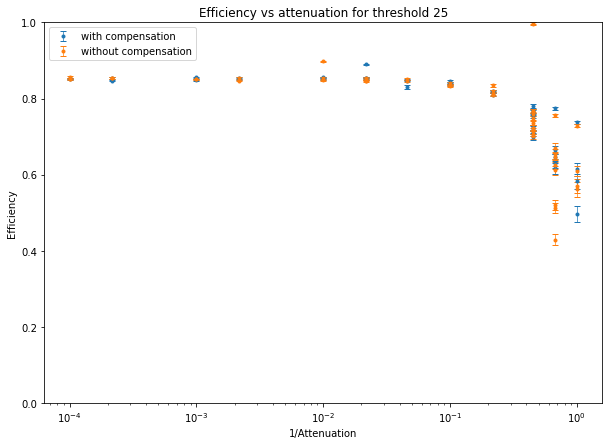

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.errorbar(list(compress(inv_attenuation, compensated_mask & np.array(threshold_mask))),
            list(compress(efficiencies, compensated_mask & np.array(threshold_mask))),
            yerr=list(compress(efficiency_errors, compensated_mask & np.array(threshold_mask))),
            ls='', lw=0.2, capsize=3, elinewidth=0.7, label=f"with compensation", marker='.')
ax.errorbar(list(compress(inv_attenuation, not_compensated_mask & np.array(threshold_mask))),
            list(compress(efficiencies, not_compensated_mask & np.array(threshold_mask))),
            yerr=list(compress(efficiency_errors, not_compensated_mask & np.array(threshold_mask))),
            ls='', lw=0.2, capsize=3, elinewidth=0.7, label=f"without compensation", marker='.')

ax.set(xlabel="1/Attenuation", ylabel="Efficiency", title="Efficiency vs attenuation for threshold 25", ylim=(0, 1), xscale='log')
ax.legend()

plt.show()

### Distinguish different HV filter values
Since the voltage drop is also caused by the resistor in the HV filter, this filter might play a role in the gain drop.

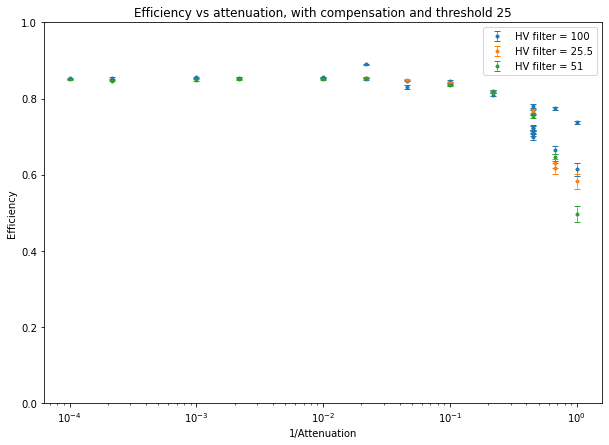

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

for i, HV in enumerate(np.unique(HV_filter)):
    HV_filter_mask = [x == HV for x in HV_filter]
    ax.errorbar(list(compress(inv_attenuation, np.array(HV_filter_mask) & np.array(compensated_mask) & np.array(threshold_mask))), 
                list(compress(efficiencies, np.array(HV_filter_mask) & np.array(compensated_mask) & np.array(threshold_mask))),
                yerr=list(compress(efficiency_errors, np.array(HV_filter_mask) & np.array(compensated_mask) & np.array(threshold_mask))), 
                ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='.', label=f"HV filter = {HV}")
    
ax.set(xlabel="1/Attenuation", ylabel="Efficiency", title="Efficiency vs attenuation, with compensation and threshold 25", ylim=(0, 1), xscale='log')
ax.legend()

plt.show()

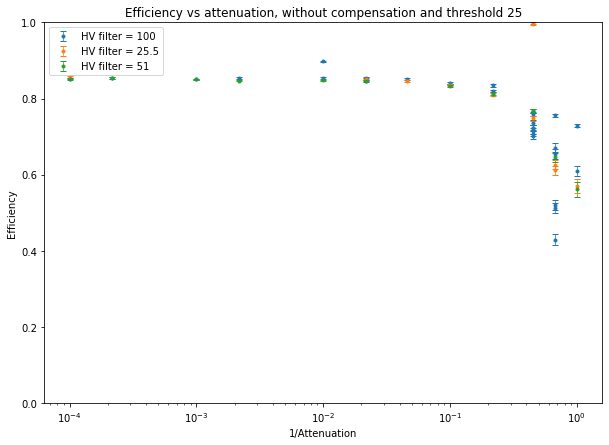

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

for HV in np.unique(HV_filter):
    HV_filter_mask = [x == HV for x in HV_filter]
    ax.errorbar(list(compress(inv_attenuation, np.array(HV_filter_mask) & np.array(not_compensated_mask) & np.array(threshold_mask))), 
                list(compress(efficiencies, np.array(HV_filter_mask) & np.array(not_compensated_mask) & np.array(threshold_mask))), 
                yerr=list(compress(efficiency_errors, np.array(HV_filter_mask) & np.array(not_compensated_mask) & np.array(threshold_mask))), 
                ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='.', label=f"HV filter = {HV}")
    
ax.set(xlabel="1/Attenuation", ylabel="Efficiency", title="Efficiency vs attenuation, without compensation and threshold 25", ylim=(0, 1), xscale='log')
ax.legend()

plt.show()

The efficiency drop is independent of the HV filter used

### Determine rate for each attenuation and plot efficiency vs rate.
Actually the important parameter is the rate of the source, not the attenuation. The rate is given in Hz per detector.

In [14]:
#attenuation_rate = read_rateatt("rate_attenuation.txt")
#rates = [attenuation_rate[att][0] if att in attenuation_rate.keys() else 0 for att in attenuation]
#rate_errors = [attenuation_rate[att][1] if att in attenuation_rate.keys() else 0 for att in attenuation]

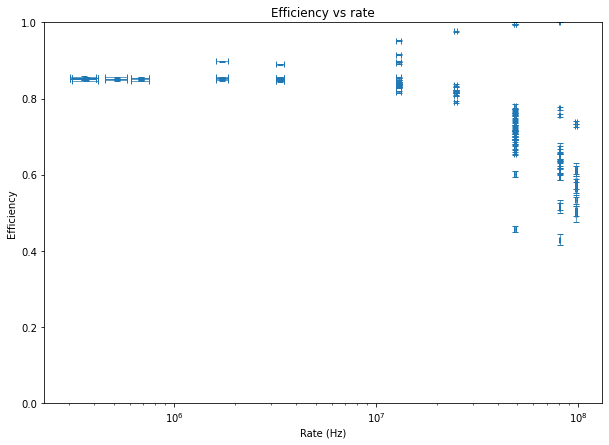

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.errorbar(rates, efficiencies, yerr=efficiency_errors, xerr=rate_errors, ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='')
ax.set(xlabel="Rate (Hz)", ylabel="Efficiency", title="Efficiency vs rate", ylim=(0, 1), xscale='log')

plt.show()

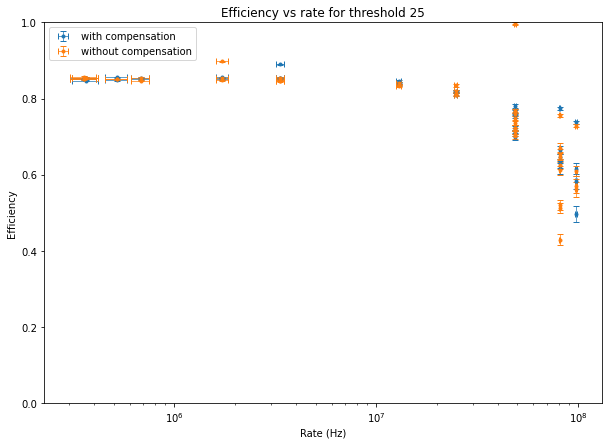

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.errorbar(list(compress(rates, compensated_mask & np.array(threshold_mask))),
            list(compress(efficiencies, compensated_mask & np.array(threshold_mask))),
            yerr=list(compress(efficiency_errors, compensated_mask & np.array(threshold_mask))),            
            xerr=list(compress(rate_errors, compensated_mask & np.array(threshold_mask))),
            ls='', lw=0.2, capsize=3, elinewidth=0.7, label=f"with compensation", marker='.')
ax.errorbar(list(compress(rates, not_compensated_mask & np.array(threshold_mask))),
            list(compress(efficiencies, not_compensated_mask & np.array(threshold_mask))),
            yerr=list(compress(efficiency_errors, not_compensated_mask & np.array(threshold_mask))),
            xerr=list(compress(rate_errors, not_compensated_mask & np.array(threshold_mask))),
            ls='', lw=0.2, capsize=3, elinewidth=0.7, label=f"without compensation", marker='.')

ax.set(xlabel="Rate (Hz)", ylabel="Efficiency", title="Efficiency vs rate for threshold 25", ylim=(0, 1), xscale='log')
ax.legend()

plt.show()

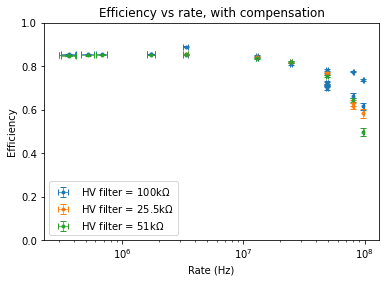

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

for i, HV in enumerate(np.unique(HV_filter)):
    HV_filter_mask = [x == HV for x in HV_filter]
    ax.errorbar(list(compress(rates, np.array(HV_filter_mask) & np.array(compensated_mask) & np.array(threshold_mask))), 
                list(compress(efficiencies, np.array(HV_filter_mask) & np.array(compensated_mask) & np.array(threshold_mask))),
                yerr=list(compress(efficiency_errors, np.array(HV_filter_mask) & np.array(compensated_mask) & np.array(threshold_mask))), 
                xerr=list(compress(rate_errors, np.array(HV_filter_mask) & np.array(compensated_mask) & np.array(threshold_mask))), 
                ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='.', label=fr"HV filter = {HV}k$\Omega$")
    
ax.set(xlabel="Rate (Hz)", ylabel="Efficiency", title="Efficiency vs rate, with compensation", ylim=(0, 1), xscale='log')
ax.legend()
plt.savefig('efficiency_vs_rate-with_compensation', dpi=300)
plt.show()

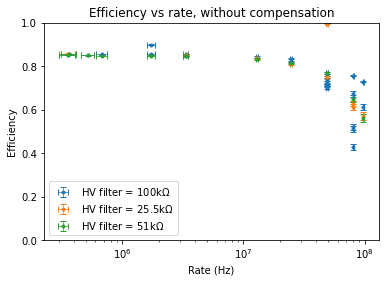

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))

for HV in np.unique(HV_filter):
    HV_filter_mask = [x == HV for x in HV_filter]
    ax.errorbar(list(compress(rates, np.array(HV_filter_mask) & np.array(not_compensated_mask) & np.array(threshold_mask))), 
                list(compress(efficiencies, np.array(HV_filter_mask) & np.array(not_compensated_mask) & np.array(threshold_mask))), 
                yerr=list(compress(efficiency_errors, np.array(HV_filter_mask) & np.array(not_compensated_mask) & np.array(threshold_mask))), 
                xerr=list(compress(rate_errors, np.array(HV_filter_mask) & np.array(not_compensated_mask) & np.array(threshold_mask))), 
                ls='', lw=0.2, capsize=3, elinewidth=0.7, marker='.', label=fr"HV filter = {HV}k$\Omega$")
    
ax.set(xlabel="Rate (Hz)", ylabel="Efficiency", title="Efficiency vs rate, without compensation", ylim=(0, 1), xscale='log')
ax.legend()
plt.savefig('efficiency_vs_rate-without_compensation', dpi=300)

plt.show()